# OSMnx

Testing the [OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/) library for loading and processing OSM data.

See these [notebooks](https://github.com/gboeing/osmnx-examples/tree/master/notebooks) for examples of using the library.

In [ ]:
# !brew install spatialindex

In [1]:
import osmnx as ox
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.10'

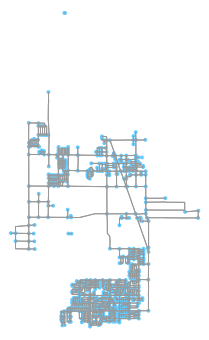

In [3]:
import osmnx as ox

G = ox.load_graphml('boeing_dataverse/06-CA-cities-street_networks-graphml/0600296_Adelanto.graphml')
fig, ax = ox.plot_graph(G)